# 1 Set Up Environment

In [1]:
# Make necessary/useful imports here
import pandas as pd
import random
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 2 Visualize The Distribution of Target Variables 'homebuyers' And 'first_homebuyers'

In [2]:
demo_df = pd.read_csv("data/zip9_demographics_coded_pv.csv", dtype={'zip5': str})


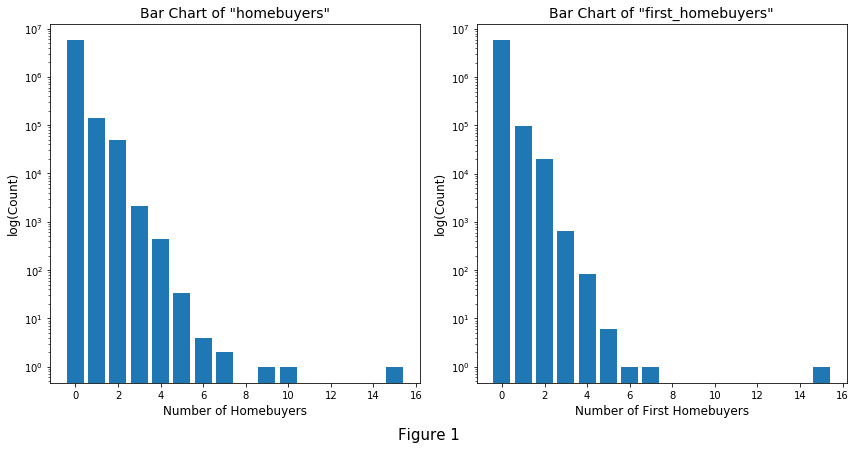

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].bar(demo_df['homebuyers'].value_counts().index, demo_df['homebuyers'].value_counts().values)
ax[1].bar(demo_df['first_homebuyers'].value_counts().index, demo_df['first_homebuyers'].value_counts().values)
ax[0].set_yscale('log')
ax[0].set_xlabel('Number of Homebuyers', fontsize = 12)
ax[0].set_ylabel('log(Count)', fontsize = 12)
ax[0].set_title('Bar Chart of "homebuyers"', fontsize = 14)

ax[1].set_yscale('log')
ax[1].set_xlabel('Number of First Homebuyers', fontsize = 12)
ax[1].set_ylabel('log(Count)', fontsize = 12)
ax[1].set_title('Bar Chart of "first_homebuyers"', fontsize = 14)
fig.suptitle(t = 'Figure 1', y = 0, fontsize = 15)
plt.tight_layout()

Above bar charts show the distribution of number of homebuyers and the number of first homebuyers. From the plots above, we could find that the dataset is imbalanced, most records are with 0 homebuyers. So, we would like to downsample the imbalanced data.

# 3 Downsample Imbalanced Dataset

In [4]:
# Treat zero as majority calss and treat non-zero as minority class. Do downsampling on the dataset demo_df.

from sklearn.utils import resample
zero_homebuyers = demo_df[demo_df['homebuyers']==0]  # number of homebuyers equals to 0
nonzero_homebuyers = demo_df[demo_df['homebuyers']>0]  # number of homebuyers larger than 0

zero_downsampled = resample(zero_homebuyers,
                            replace = False, # sample without replacement
                            n_samples = len(nonzero_homebuyers), # match minority n
                            random_state = 27) # reproducible results
downsampled = pd.concat([zero_downsampled, nonzero_homebuyers])

In [5]:
# Sample from downsampled dataset

downsampled = resample(downsampled, replace = False, n_samples= int(len(downsampled) * 0.2), random_state = 123)

# Encode homebuyers and first_homebuyers as binary target 
downsampled['target'] = np.where(downsampled['homebuyers']==0, 0, 1)
downsampled['target2'] = np.where(downsampled['first_homebuyers']==0, 0, 1)

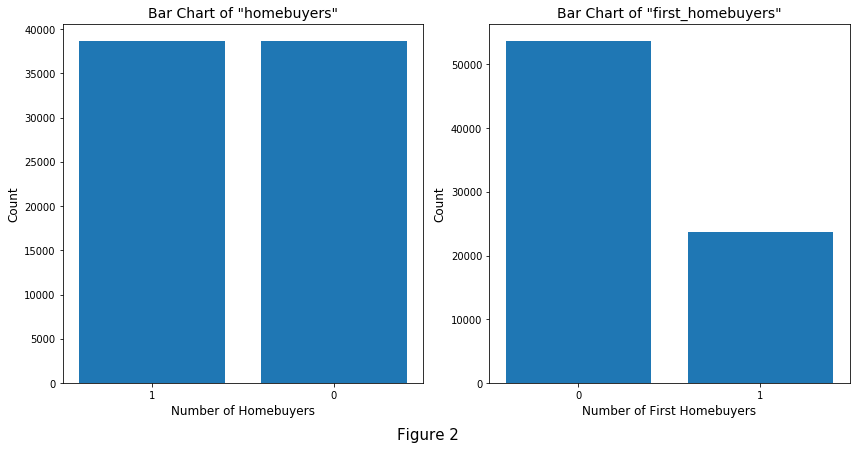

In [6]:
# plot balanced data
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].bar(downsampled['target'].value_counts().index.map(str), downsampled['target'].value_counts().values)
ax[1].bar(downsampled['target2'].value_counts().index.map(str), downsampled['target2'].value_counts().values)
ax[0].set_xlabel('Number of Homebuyers', fontsize = 12)
ax[0].set_ylabel('Count', fontsize = 12)
ax[0].set_title('Bar Chart of "homebuyers"', fontsize = 14)

ax[1].set_xlabel('Number of First Homebuyers', fontsize = 12)
ax[1].set_ylabel('Count', fontsize = 12)
ax[1].set_title('Bar Chart of "first_homebuyers"', fontsize = 14)
fig.suptitle(t = 'Figure 2', y = 0, fontsize = 15)
plt.tight_layout()

From the plots above, we could find that the dataset for homebuyers is now balanced. However, since we sampled data by homebuyers, the downsampled dataset for first homebuyers is still not balanced but more balanced than original data.

# 4 Feature Selection

## 4.1 Missing Value

In [7]:
# Obtain rows that need to drop
skip_row = list(np.array(list(set(np.arange(0, 6009259, 1)) - set(downsampled.index.to_list())))+1)

In [8]:
# Read zip9_coded_20190X_pv.csv files and drop the rows in skip_row.

April_df = pd.read_csv("data/zip9_coded_201904_pv.csv", skiprows=skip_row)
May_df = pd.read_csv("data/zip9_coded_201905_pv.csv", skiprows=skip_row)
June_df = pd.read_csv("data/zip9_coded_201906_pv.csv", skiprows=skip_row)
July_df = pd.read_csv("data/zip9_coded_201907_pv.csv", skiprows=skip_row)
Aug_df = pd.read_csv("data/zip9_coded_201908_pv.csv", skiprows=skip_row)
Sep_df = pd.read_csv("data/zip9_coded_201909_pv.csv", skiprows=skip_row)

In [9]:
# Concat all the files and calculate the average of each feature for each zip9_code.
features = pd.concat([April_df, May_df, June_df, July_df, Aug_df, Sep_df], axis = 0, ignore_index= True)
features_avg = features.groupby('zip9_code').mean()

In [10]:
# Using only total features, including household count, person count
useful_cols = ['bankcard_limit', 'bankcard_balance', 'bankcard_trades',
       'bankcard_util', 'total_revolving_limit', 'total_revolving_balance',
       'total_revolving_trades', 'total_revolving_util', 'total_mortgage_limit',
       'total_mortgage_balance', 'total_mortgage_trades',
       'mortgage1_loan_to_value', 
       'total_homeequity_limit',
       'total_homeequity_balance', 'total_homeequity_trades',
       'homeequity1_loan_to_value', 'autoloan_open', 'studentloan_open',
       'bankcard_open', 'homeequity_open', 'mortgage_open']
useful_features = features_avg[useful_cols]

### 4.1.1 Target 1: "homebuyers"

In [11]:
# Join with target and other features
useful_features1 = pd.merge(useful_features, 
                           downsampled[['zip9_code', 'age', 'target', 'household_count', 'person_count']], 
                           on = 'zip9_code', how = 'left')

In [12]:
# Delete columnns whose missing rate are above 50%.
missing_values = useful_features1.isna().sum()
missing_rate = missing_values / len(useful_features1)
drop_missing_df = useful_features1[useful_features1.columns[missing_rate < 0.5]]
# Using only total features, including household count, person count
X = drop_missing_df.drop(columns = ['target', 'zip9_code'])
y = drop_missing_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state=0)

In [13]:
X_train.columns

Index(['bankcard_limit', 'bankcard_balance', 'bankcard_trades',
       'bankcard_util', 'total_revolving_limit', 'total_revolving_balance',
       'total_revolving_trades', 'total_revolving_util',
       'total_mortgage_limit', 'total_mortgage_balance',
       'total_mortgage_trades', 'mortgage1_loan_to_value',
       'total_homeequity_limit', 'total_homeequity_balance',
       'total_homeequity_trades', 'homeequity1_loan_to_value', 'autoloan_open',
       'studentloan_open', 'bankcard_open', 'homeequity_open', 'mortgage_open',
       'age', 'household_count', 'person_count'],
      dtype='object')

### 4.1.1 Target 1: "homebuyers"

In [14]:
# Join with target and other features
useful_features2 = pd.merge(useful_features, 
                           downsampled[['zip9_code', 'age', 'target2', 'household_count', 'person_count']], 
                           on = 'zip9_code', how = 'left')

# Delete columnns whose missing rate are above 50%.
missing_values2 = useful_features2.isna().sum()
missing_rate2 = missing_values2 / len(useful_features2)
drop_missing_df2 = useful_features2[useful_features2.columns[missing_rate2 < 0.5]]
# Using only total features, including household count, person count
X2 = drop_missing_df2.drop(columns = ['target2', 'zip9_code'])
y2 = drop_missing_df2['target2']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.16, random_state=0)

In [15]:
X_train2.columns

Index(['bankcard_limit', 'bankcard_balance', 'bankcard_trades',
       'bankcard_util', 'total_revolving_limit', 'total_revolving_balance',
       'total_revolving_trades', 'total_revolving_util',
       'total_mortgage_limit', 'total_mortgage_balance',
       'total_mortgage_trades', 'mortgage1_loan_to_value',
       'total_homeequity_limit', 'total_homeequity_balance',
       'total_homeequity_trades', 'homeequity1_loan_to_value', 'autoloan_open',
       'studentloan_open', 'bankcard_open', 'homeequity_open', 'mortgage_open',
       'age', 'household_count', 'person_count'],
      dtype='object')

## 4.2 Correlation Between Features

Text(0.5, 0, 'Figure 3')

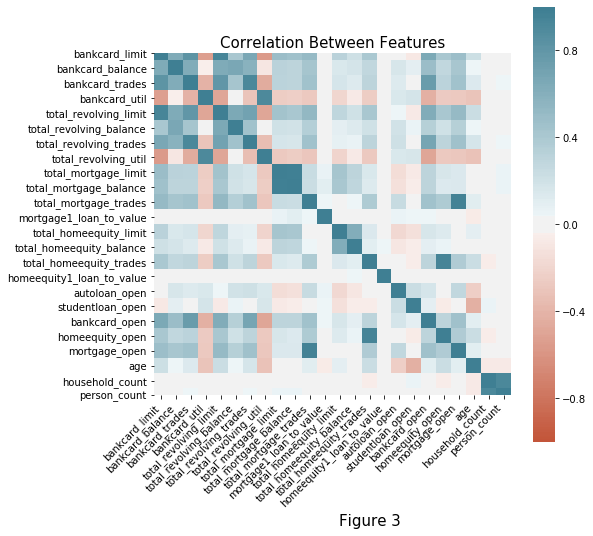

In [16]:
corr = drop_missing_df.drop(columns = ['target', 'zip9_code']).corr()

plt.figure(figsize = (8, 8))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Correlation Between Features', fontsize = 15)
plt.suptitle(t = 'Figure 3', y = 0, fontsize = 15)

## 4.3 Correlation Between Features And Target Variable

In [17]:
target_corr = drop_missing_df.corr()['target'].sort_values(ascending=False)
target_corr2 = drop_missing_df2.corr()['target2'].sort_values(ascending=False)

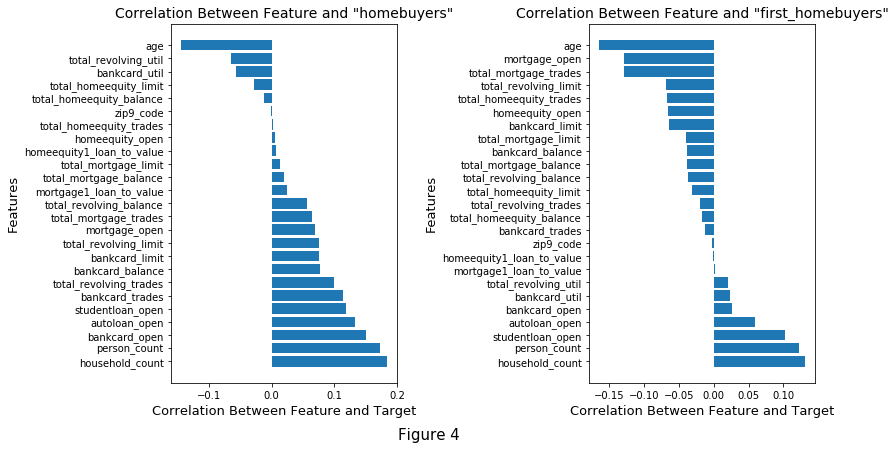

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].barh(target_corr.index[1:], target_corr.values[1:])
ax[1].barh(target_corr2.index[1:], target_corr2.values[1:])

ax[0].set_xlabel('Correlation Between Feature and Target', fontsize = 13)
ax[1].set_xlabel('Correlation Between Feature and Target', fontsize = 13)
ax[0].set_ylabel('Features', fontsize = 13)
ax[1].set_ylabel('Features', fontsize = 13)
ax[0].set_title('Correlation Between Feature and "homebuyers"', fontsize = 14)
ax[1].set_title('Correlation Between Feature and "first_homebuyers"', fontsize = 14)
fig.suptitle(t = 'Figure 4', y = 0, fontsize = 15)
plt.tight_layout()

## 4.4 Visualizing Distribution of Features By Label

/Users/liuboyu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/liuboyu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 0.223, 'Figure 5')

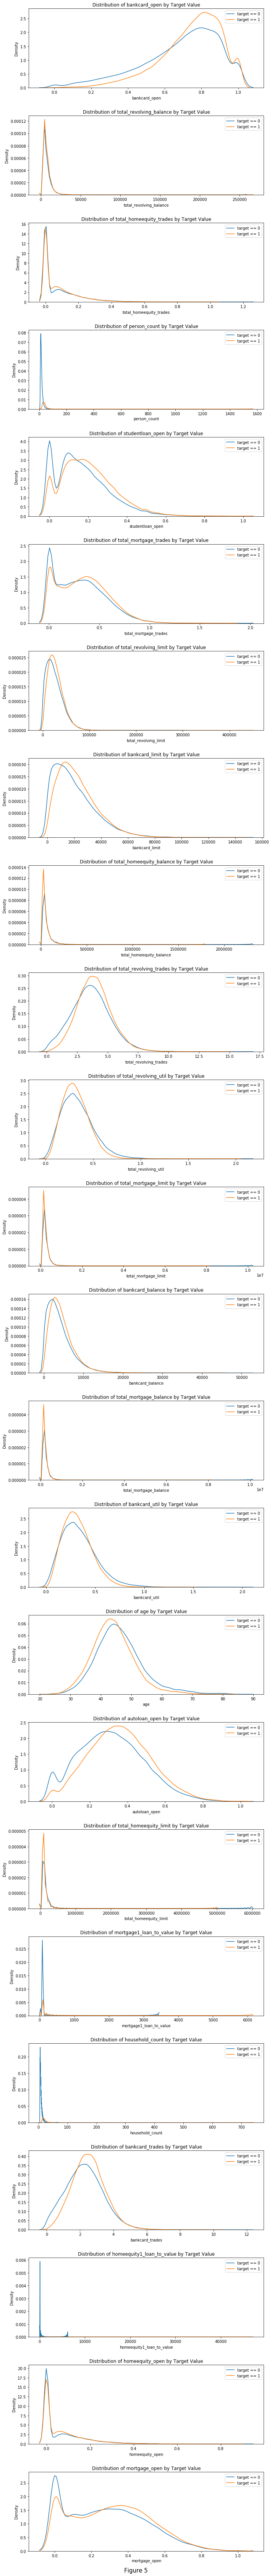

In [19]:
plt.figure(figsize = (10, 120))

feature_list = list(set(drop_missing_df.columns) - set(['zip9_code',  'target']))

# iterate through the sources
for i, source in enumerate(feature_list):
    
    # create a new subplot for each source
    plt.subplot(31, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(drop_missing_df.loc[drop_missing_df['target'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(drop_missing_df.loc[drop_missing_df['target'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.suptitle(t = 'Figure 5', y = 0.223, fontsize = 15)

From the distribution of the features, we can identify several attributes of homebuyers: larger bankcard balance, larger bankcard limit, younger age, more bankcard trades, higher autoloan open rate and from a ziparea with larger population and more households.

# 5 Model Selection

## 5.1 Loss Function

In [20]:
def loss_function_1(y_pred, y_labels):
    size = y_pred.size
    differences = y_pred - y_labels
    differences_square = differences*differences
    differences_square_sum = np.sum(differences_square)
    
    return differences_square_sum/size

# Likewise, expects two numpy vectors of equal size, and outputs average scaled square difference
def loss_function_2(y_pred, y_labels):
    size = y_pred.size
    differences = y_pred - y_labels
    
    # If the prediction is smaller than the label, then we have underpredicted, scale this up
    under = np.where(differences < 0, differences, 0)
    over = np.where(differences > 0, differences, 0)
    under_square_scaled = under*under*10
    over_square = over*over
    square_sum = np.sum(under_square_scaled) + np.sum(over_square)
    
    return square_sum/size

## 5.2 Logistic Regression

### 5.2.1 Target 1: "homebuyers"

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

lr_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), 
                     StandardScaler(), 
                        LogisticRegression(solver = 'lbfgs', max_iter = 10000))

param_grid = {'logisticregression__C': np.logspace(-2, 2, 5)}
grid1 = GridSearchCV(lr_pipe, param_grid, cv=5)
grid1.fit(X_train, y_train)
grid1.score(X_test, y_test)

0.6308177117000646

In [22]:
y_pred = grid1.predict(X_test)

print("Loss 1:", loss_function_1(y_pred, y_test))
print("Loss 2:", loss_function_2(y_pred, y_test))

Loss 1: 0.3691822882999354
Loss 2: 2.1239495798319328


Text(0.5, 0, 'Figure 6')

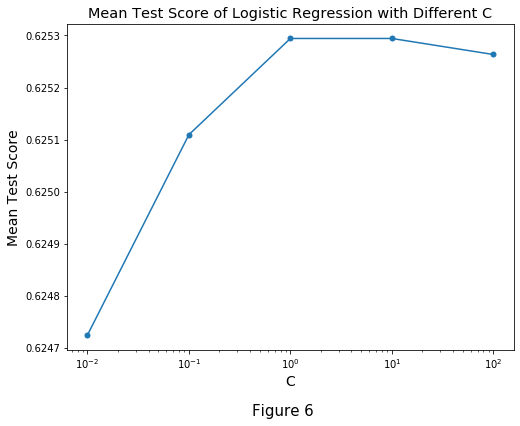

In [24]:
## Visualize the performance as function of the parameters for this model
# Save the results into a dataframe
results_1 = pd.DataFrame(grid1.cv_results_) # Store the results in the form of dataframe.
plt.figure(figsize = (8, 6))
plt.plot(np.logspace(-2, 2, 5), np.array(results_1['mean_test_score']), marker = 'o', markersize = 5)

plt.xscale('log')
plt.xlabel('C', fontsize = 14)
plt.ylabel('Mean Test Score', fontsize = 14)
plt.title('Mean Test Score of Logistic Regression with Different C', fontsize = 14.5)
plt.suptitle(t = 'Figure 6', y = 0, fontsize = 15)

### 5.2.2 Target 2: "first_homebuyers"

In [25]:
lr_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), 
                     StandardScaler(), 
                        LogisticRegression(solver = 'lbfgs', max_iter = 10000))

param_grid = {'logisticregression__C': np.logspace(-2, 2, 5)}
grid2 = GridSearchCV(lr_pipe, param_grid, cv=5)
grid2.fit(X_train2, y_train2)
grid2.score(X_test2, y_test2)

0.7070943762120233

In [26]:
y_pred2 = grid2.predict(X_test2)

print("Loss 1:", loss_function_1(y_pred2, y_test2))
print("Loss 2:", loss_function_2(y_pred2, y_test2))

Loss 1: 0.29290562378797674
Loss 2: 2.6308985132514544


Text(0.5, 0, 'Figure 7')

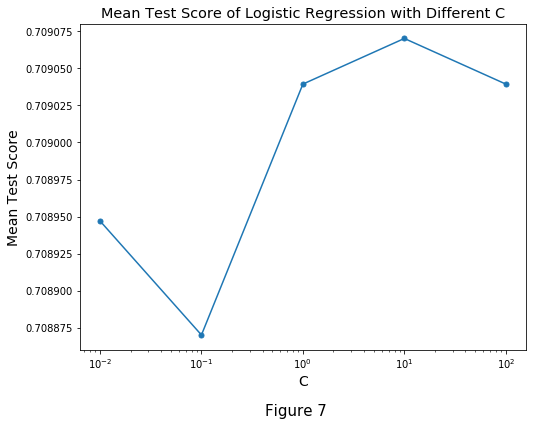

In [27]:
## Visualize the performance as function of the parameters for this model
# Save the results into a dataframe
results_2 = pd.DataFrame(grid2.cv_results_) # Store the results in the form of dataframe.
plt.figure(figsize = (8, 6))
plt.plot(np.logspace(-2, 2, 5), np.array(results_2['mean_test_score']), marker = 'o', markersize = 5)

plt.xscale('log')
plt.xlabel('C', fontsize = 14)
plt.ylabel('Mean Test Score', fontsize = 14)
plt.title('Mean Test Score of Logistic Regression with Different C', fontsize = 14.5)
plt.suptitle(t = 'Figure 7', y = 0, fontsize = 15)

## 5.3 Random Forest

### 5.3.1 Target 1: "homebuyers"

In [28]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'randomforestclassifier__max_depth': np.arange(5, 30, 5)}
rf_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), RandomForestClassifier(n_estimators=100)) 
grid3 = GridSearchCV(rf_pipe, param_grid, cv=10)
grid3.fit(X_train, y_train)
grid3.score(X_test, y_test)

0.6363122171945701

In [30]:
y_pred = grid3.predict(X_test)
print("Loss 1:", loss_function_1(y_pred, y_test))
print("Loss 2:", loss_function_2(y_pred, y_test))

Loss 1: 0.36368778280542985
Loss 2: 2.0660956690368457


### 5.3.2 Target 2: "first_homebuyers"

In [31]:
param_grid = {'randomforestclassifier__max_depth': np.arange(5, 50, 10)}
rf_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), RandomForestClassifier(n_estimators=100)) 
grid = GridSearchCV(rf_pipe, param_grid, cv=10)
grid.fit(X_train2, y_train2)
grid.score(X_test2, y_test2)

0.7066095669036846

In [32]:
y_pred = grid.predict(X_test)
print("Loss 1:", loss_function_1(y_pred2, y_test2))
print("Loss 2:", loss_function_2(y_pred2, y_test2))

Loss 1: 0.29290562378797674
Loss 2: 2.6308985132514544


## 5.4 Hist Gradient Boosting

### 5.4.1 Target 1: "homebuyers"

In [33]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_pipe = make_pipeline(SimpleImputer(strategy = 'mean'),HistGradientBoostingClassifier(random_state = 20))

param_grid = {'histgradientboostingclassifier__learning_rate': np.arange(0.1, 1, 0.2),
              'histgradientboostingclassifier__max_depth': np.arange(5, 30, 5)}
grid5 = GridSearchCV(hgb_pipe, param_grid, cv=5)
grid5.fit(X_train, y_train)
grid5.score(X_test, y_test)

0.6370394311570782

In [34]:
y_pred = grid5.predict(X_test)
print("Loss 1:", loss_function_1(y_pred, y_test))
print("Loss 2:", loss_function_2(y_pred, y_test))

Loss 1: 0.36296056884292177
Loss 2: 2.045733678086619


### 5.4.2 Target 2: "first_homebuyers"

In [35]:
hgb_pipe = make_pipeline(SimpleImputer(strategy = 'mean'),HistGradientBoostingClassifier(random_state = 20))

param_grid = {'histgradientboostingclassifier__learning_rate': np.arange(0.1, 1, 0.2),
              'histgradientboostingclassifier__max_depth': np.arange(5, 30, 5)}
grid6 = GridSearchCV(hgb_pipe, param_grid, cv=5)
grid6.fit(X_train2, y_train2)
grid6.score(X_test2, y_test2)

0.7091952165481578

In [36]:
y_pred2 = grid6.predict(X_test2)
print("Loss 1:", loss_function_1(y_pred2, y_test2))
print("Loss 2:", loss_function_2(y_pred2, y_test2))

Loss 1: 0.2908047834518423
Loss 2: 2.5778926955397545


## 5.5 XGBoost

### 5.5.1 Target 1: "homebuyers"

In [37]:
from xgboost import XGBClassifier
param_grid = {'learning_rate': np.arange(0.1, 1, 0.2)}
grid7 = GridSearchCV(XGBClassifier(colsample_bytree = 0.8), param_grid, cv=5)
grid7.fit(X_train, y_train)
grid7.score(X_test, y_test)

0.6367970265029088

In [38]:
y_pred = grid7.predict(X_test)
print("Loss 1:", loss_function_1(y_pred, y_test))
print("Loss 2:", loss_function_2(y_pred, y_test))

Loss 1: 0.36320297349709113
Loss 2: 1.995798319327731


### 5.5.2 Target 2: "first_homebuyers"

In [39]:
param_grid = {'learning_rate': np.arange(0.1, 1, 0.2)}
grid8 = GridSearchCV(XGBClassifier(colsample_bytree = 0.8), param_grid, cv=10)
grid8.fit(X_train2, y_train2)
grid8.score(X_test2, y_test2)

0.7081447963800905

In [40]:
y_pred2 = grid8.predict(X_test2)
print("Loss 1:", loss_function_1(y_pred2, y_test2))
print("Loss 2:", loss_function_2(y_pred2, y_test2))

Loss 1: 0.2918552036199095
Loss 2: 2.6153038138332256
